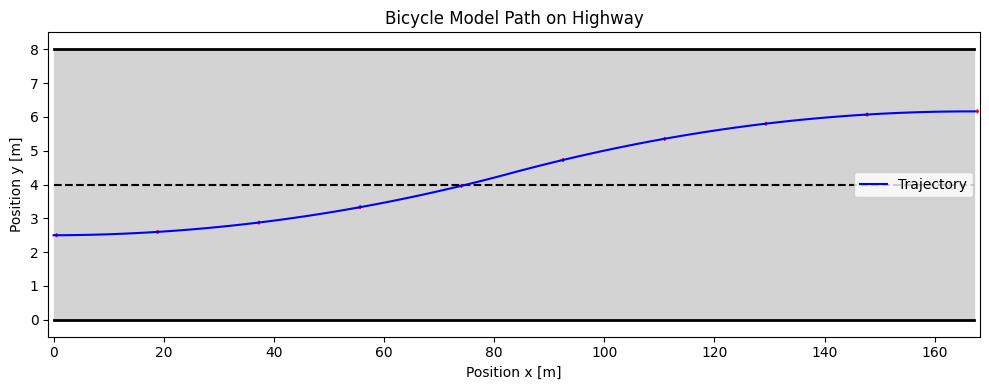

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Vehicle & model parameters (now lf = lr = 1.5 m)
lf, lr = 1.5, 1.5       

# 2. Simulation parameters
dt    = 0.05    # [s] time step
Nsim  = 100     # number of steps

# 3. Allocate state arrays: x, y, heading ψ, speed v
x   = np.zeros(Nsim+1)
y   = np.zeros(Nsim+1)
psi = np.zeros(Nsim+1)
v   = np.zeros(Nsim+1)

# 4. Initial condition: start at (0,1.5) m, heading=0, 120 km/h → m/s
x[0], y[0], psi[0] = 0.0, 2.5, 0.0
v[0] = 120/3.6

# 5. Piecewise‐constant inputs (acceleration, steering)
u1 = np.array([ 0.1,   5e-4 * np.pi])   # accelerate + slight right steer
u2 = np.array([-0.1,  -5e-4 * np.pi])   # decelerate + slight left steer
U  = np.vstack([u1]*(Nsim//2) + [u2]*(Nsim//2))

# 6. Euler integration of kinematic bicycle model
for k in range(Nsim):
    a_k, delta_k = U[k]
    beta   = np.arctan(lr/(lf+lr) * np.tan(delta_k))
    xdot   = v[k] * np.cos(psi[k] + beta)
    ydot   = v[k] * np.sin(psi[k] + beta)
    psidot = v[k]/lr * np.sin(beta)
    vdot   = a_k

    x[k+1]   = x[k]   + dt * xdot
    y[k+1]   = y[k]   + dt * ydot
    psi[k+1] = psi[k] + dt * psidot
    v[k+1]   = v[k]   + dt * vdot

# 7. Plotting: road from y=0 to y_max=8, dotted center at y=4
y_min, y_max = 0, 8

fig, ax = plt.subplots(figsize=(10,4))
# road fill & boundaries
ax.fill_between([x.min(), x.max()], y_min, y_max, color='lightgrey')
ax.plot([x.min(), x.max()], [y_min, y_min], 'k', lw=2)
ax.plot([x.min(), x.max()], [y_max, y_max], 'k', lw=2)

# dotted center line at y=4
ax.plot([x.min(), x.max()], [4, 4], linestyle='--', color='k')

# trajectory curve
ax.plot(x, y, 'b-', label='Trajectory')

# heading arrows at 10 evenly‐spaced points
for i in np.linspace(0, Nsim, 10, dtype=int):
    dx = np.cos(psi[i]) * 0.5
    dy = np.sin(psi[i]) * 0.5
    ax.arrow(x[i], y[i], dx, dy,
             head_width=0.1, head_length=0.2,
             fc='red', ec='red')

ax.set_xlabel('Position x [m]')
ax.set_ylabel('Position y [m]')
ax.set_title('Bicycle Model Path on Highway')
ax.set_xlim(x.min() - 1, x.max() + 1)
ax.set_ylim(y_min - 0.5, y_max + 0.5)
ax.legend()
plt.tight_layout()
plt.show()